# Machine Learning for Cybersecurity - Lab 02

**Name:** Mukta Maheshwari </br>
**NETID:** mm11070

---



## Import package

In [26]:
#importing libraries
import pandas as pd
import seaborn as sns
import keras
from tqdm import tqdm
import os
import tarfile
import requests
import re
import sys
import warnings
warnings.filterwarnings('ignore')
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.font_manager as font_manager
import cv2

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
warnings.filterwarnings("ignore")

## BadNets
It shows the original badnet and it will print out the accuracy and attack success rate for the original badnet

In [29]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

In [32]:
clean_data_filename = '/content/drive/MyDrive/Lab2_mm11070/lab3/data/cl/valid.h5'
poisoned_data_filename = '/content/drive/MyDrive/Lab2_mm11070/lab3/data/bd/bd_valid.h5'
model_filename = '/content/drive/MyDrive/Lab2_mm11070/lab3/models/bd_net.h5'

In [33]:
#loading data
def main():
    cl_x_test, cl_y_test = data_loader(clean_data_filename)
    bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

    bd_model = keras.models.load_model(model_filename)

    cl_label_p = np.argmax(bd_model.predict(cl_x_test), axis=1)
    clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
    print('Clean Classification accuracy:', clean_accuracy)
    
    bd_label_p = np.argmax(bd_model.predict(bd_x_test), axis=1)
    asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
    print('Attack Success Rate:', asr)

if __name__ == '__main__':
    main()

361/361 [==============================] - 8s 20ms/step
Clean Classification accuracy: 98.64899974019225
361/361 [==============================] - 7s 19ms/step
Attack Success Rate: 100.0


### Seeing the model structure

In [34]:
model = keras.models.load_model(model_filename)

In [35]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

Visualizing the data to see the clean data

In [36]:
x_data, y_data = data_loader(clean_data_filename)

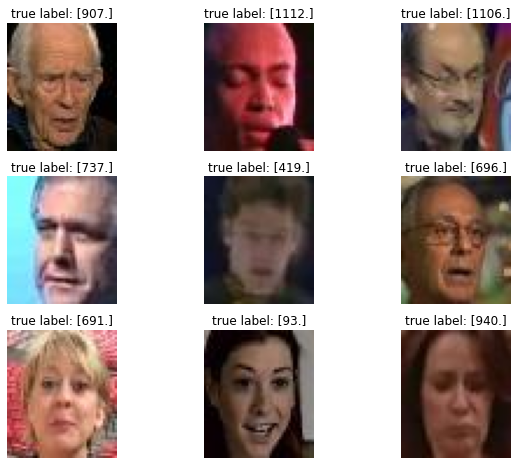

In [37]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

Visualizing the sunglasses poisioned test data

In [38]:
x_poisoned_data, y_poisoned_data = data_loader(poisoned_data_filename)

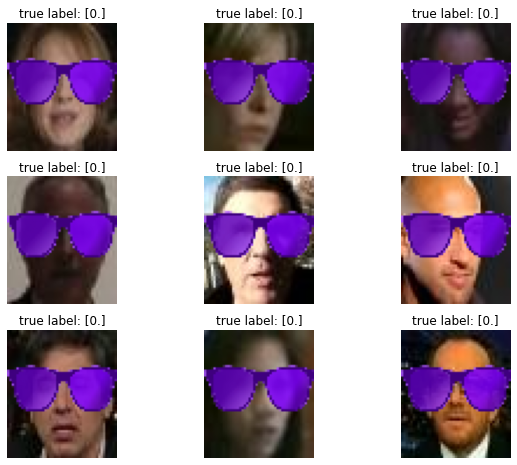

In [39]:
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.random.randint(x_poisoned_data.shape[0], size=1)
  img, label = (x_poisoned_data[index], y_poisoned_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("true label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [40]:
# clearing the session
keras.backend.clear_session()

## Prune defense
For Pruning the model, the steps are as follows $-$

1. It is determined whether the final pooling layer, "(pool 3)," is activated.
2. Pruning ALWAYS begins with the smallest average activation. There are 60 total channels in the convolution layer "(conv 3)," and we need to find the index to prune.

In [41]:
# getting the data
cl_x_test, cl_y_test = data_loader(clean_data_filename)
bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

In [42]:
clean_data_acc = 98.64899974019225        #from the main function cell - clean data accuracy
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights()) 
prune_index = []
clean_acc = []
asrate = []
saved_model = np.zeros(3,dtype=bool)

# getting the activation from the last pooling layer
layer_output=model_copy.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=model_copy.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(cl_x_test)  
temp = np.mean(intermediate_prediction,axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

for channel_index in tqdm(seq): 
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  model_copy.layers[5].set_weights([weight_0, bias_0])
  cl_label_p = np.argmax(model_copy.predict(cl_x_test), axis=1)
  clean_accuracy = np.mean(np.equal(cl_label_p, cl_y_test))*100
  if (clean_data_acc-clean_accuracy >= 2 and not saved_model[0]):
    print("The accuracy drops at least 2%, saved the model")
    model_copy.save('model_X=2.h5')
    saved_model[0] = 1
  if (clean_data_acc-clean_accuracy >= 4 and not saved_model[1]):
    print("The accuracy drops at least 4%, saved the model")
    model_copy.save('model_X=4.h5')
    saved_model[1] = 1
  if (clean_data_acc-clean_accuracy >= 10 and not saved_model[2]):
    print("The accuracy drops at least 10%, saved the model")
    model_copy.save('model_X=10.h5')
    saved_model[2] = 1
  clean_acc.append(clean_accuracy)
  bd_label_p = np.argmax(model_copy.predict(bd_x_test), axis=1)
  asr = np.mean(np.equal(bd_label_p, bd_y_test))*100
  asrate.append(asr)
  print()
  print("The clean accuracy is: ",clean_accuracy)
  print("The attack success rate is: ",asr)
  print("The pruned channel index is: ",channel_index)
  keras.backend.clear_session()


361/361 [==============================] - 7s 18ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 7s 20ms/step


  2%|▏         | 1/60 [00:15<15:43, 15.99s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0
361/361 [==============================] - 7s 20ms/step


  3%|▎         | 2/60 [00:31<15:25, 15.96s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26
361/361 [==============================] - 7s 20ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27


  5%|▌         | 3/60 [00:50<16:20, 17.20s/it]

361/361 [==============================] - 8s 21ms/step


  7%|▋         | 4/60 [01:06<15:39, 16.77s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30
361/361 [==============================] - 8s 22ms/step


  8%|▊         | 5/60 [01:27<16:49, 18.36s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31
361/361 [==============================] - 8s 21ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33


 10%|█         | 6/60 [01:47<16:50, 18.72s/it]

361/361 [==============================] - 9s 24ms/step


 12%|█▏        | 7/60 [02:05<16:29, 18.67s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34
361/361 [==============================] - 7s 20ms/step


 13%|█▎        | 8/60 [02:24<16:08, 18.63s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36
361/361 [==============================] - 7s 20ms/step


 15%|█▌        | 9/60 [02:42<15:48, 18.60s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37
361/361 [==============================] - 8s 22ms/step


 17%|█▋        | 10/60 [02:59<15:05, 18.11s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38
361/361 [==============================] - 8s 22ms/step


 18%|█▊        | 11/60 [03:16<14:28, 17.73s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25
361/361 [==============================] - 7s 20ms/step


 20%|██        | 12/60 [03:32<13:38, 17.05s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39
361/361 [==============================] - 7s 21ms/step


 22%|██▏       | 13/60 [03:50<13:40, 17.47s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41
361/361 [==============================] - 8s 23ms/step


 23%|██▎       | 14/60 [04:10<13:52, 18.10s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44
361/361 [==============================] - 7s 21ms/step


 25%|██▌       | 15/60 [04:26<13:04, 17.43s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45
361/361 [==============================] - 7s 20ms/step



 27%|██▋       | 16/60 [04:41<12:20, 16.82s/it]

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47
361/361 [==============================] - 7s 20ms/step


 28%|██▊       | 17/60 [04:59<12:22, 17.26s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48
361/361 [==============================] - 8s 21ms/step


 30%|███       | 18/60 [05:20<12:49, 18.33s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49
361/361 [==============================] - 7s 20ms/step


 32%|███▏      | 19/60 [05:38<12:31, 18.32s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50
361/361 [==============================] - 7s 21ms/step


 33%|███▎      | 20/60 [05:54<11:44, 17.61s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53
361/361 [==============================] - 7s 20ms/step


 35%|███▌      | 21/60 [06:13<11:38, 17.91s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55
361/361 [==============================] - 8s 21ms/step


 37%|███▋      | 22/60 [06:29<10:55, 17.24s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40
361/361 [==============================] - 7s 19ms/step


 38%|███▊      | 23/60 [06:47<10:46, 17.47s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24
361/361 [==============================] - 7s 20ms/step


 40%|████      | 24/60 [07:05<10:39, 17.75s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59
361/361 [==============================] - 7s 20ms/step


 42%|████▏     | 25/60 [07:20<09:54, 16.98s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9
361/361 [==============================] - 7s 19ms/step


 43%|████▎     | 26/60 [07:38<09:47, 17.27s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2
361/361 [==============================] - 7s 20ms/step


 45%|████▌     | 27/60 [07:55<09:28, 17.23s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12
361/361 [==============================] - 7s 20ms/step


 47%|████▋     | 28/60 [08:11<08:58, 16.84s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13
361/361 [==============================] - 9s 24ms/step


 48%|████▊     | 29/60 [08:31<09:09, 17.72s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17
361/361 [==============================] - 7s 20ms/step


 50%|█████     | 30/60 [08:47<08:37, 17.26s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14
361/361 [==============================] - 7s 19ms/step


 52%|█████▏    | 31/60 [09:03<08:07, 16.80s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15
361/361 [==============================] - 7s 19ms/step


 53%|█████▎    | 32/60 [09:21<08:01, 17.20s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23
361/361 [==============================] - 7s 19ms/step


 55%|█████▌    | 33/60 [09:37<07:30, 16.68s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6
361/361 [==============================] - 10s 26ms/step


 57%|█████▋    | 34/60 [09:57<07:45, 17.89s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51
361/361 [==============================] - 7s 19ms/step


 58%|█████▊    | 35/60 [10:13<07:13, 17.34s/it]


The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32
361/361 [==============================] - 7s 19ms/step


 60%|██████    | 36/60 [10:32<07:03, 17.66s/it]


The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22
361/361 [==============================] - 7s 18ms/step


 62%|██████▏   | 37/60 [10:47<06:29, 16.92s/it]


The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21
361/361 [==============================] - 7s 18ms/step


 63%|██████▎   | 38/60 [11:01<05:53, 16.07s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20
361/361 [==============================] - 7s 18ms/step


 65%|██████▌   | 39/60 [11:15<05:25, 15.52s/it]


The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19
361/361 [==============================] - 7s 19ms/step


 67%|██████▋   | 40/60 [11:30<05:03, 15.16s/it]


The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43
361/361 [==============================] - 7s 20ms/step

The clean accuracy is:  98.53641638520828
The attack success rate is:  

 68%|██████▊   | 41/60 [11:47<05:00, 15.84s/it]

100.0
The pruned channel index is:  58
361/361 [==============================] - 7s 19ms/step


 70%|███████   | 42/60 [12:05<04:57, 16.54s/it]


The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3
361/361 [==============================] - 7s 19ms/step


 72%|███████▏  | 43/60 [12:22<04:43, 16.65s/it]


The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42
361/361 [==============================] - 7s 19ms/step


 73%|███████▎  | 44/60 [12:41<04:35, 17.23s/it]


The clean accuracy is:  97.50584567420108
The attack success rate is:  100.0
The pruned channel index is:  1
361/361 [==============================] - 7s 19ms/step


The accuracy drops at least 2%, saved the model
361/361 [==============================] - 7s 19ms/step


 75%|███████▌  | 45/60 [12:59<04:22, 17.47s/it]


The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29
361/361 [==============================] - 7s 19ms/step


 77%|███████▋  | 46/60 [13:20<04:20, 18.60s/it]


The clean accuracy is:  95.20221702606739
The attack success rate is:  99.9913397419243
The pruned channel index is:  16
361/361 [==============================] - 7s 19ms/step

The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56


 78%|███████▊  | 47/60 [13:34<03:45, 17.36s/it]

361/361 [==============================] - 7s 19ms/step


The accuracy drops at least 4%, saved the model
361/361 [==============================] - 7s 19ms/step


 80%|████████  | 48/60 [13:49<03:17, 16.49s/it]


The clean accuracy is:  92.09318437689443
The attack success rate is:  99.9913397419243
The pruned channel index is:  46
361/361 [==============================] - 7s 20ms/step


 82%|████████▏ | 49/60 [14:04<02:57, 16.09s/it]


The clean accuracy is:  91.49562656967177
The attack success rate is:  99.9913397419243
The pruned channel index is:  5
361/361 [==============================] - 8s 21ms/step


 83%|████████▎ | 50/60 [14:19<02:38, 15.88s/it]


The clean accuracy is:  91.01931237550879
The attack success rate is:  99.98267948384861
The pruned channel index is:  8
361/361 [==============================] - 8s 21ms/step


 85%|████████▌ | 51/60 [14:35<02:21, 15.72s/it]


The clean accuracy is:  89.17467740538669
The attack success rate is:  80.73958603966398
The pruned channel index is:  11
361/361 [==============================] - 7s 19ms/step


The accuracy drops at least 10%, saved the model
361/361 [==============================] - 7s 19ms/step


 87%|████████▋ | 52/60 [14:50<02:03, 15.42s/it]


The clean accuracy is:  84.43751623798389
The attack success rate is:  77.015675067117
The pruned channel index is:  54
361/361 [==============================] - 7s 19ms/step


 88%|████████▊ | 53/60 [15:04<01:46, 15.24s/it]


The clean accuracy is:  76.48739932449988
The attack success rate is:  35.71490430414826
The pruned channel index is:  10
361/361 [==============================] - 7s 19ms/step


 90%|█████████ | 54/60 [15:19<01:30, 15.08s/it]


The clean accuracy is:  54.8627349095003
The attack success rate is:  6.954187234779596
The pruned channel index is:  28
361/361 [==============================] - 7s 19ms/step


 92%|█████████▏| 55/60 [15:34<01:14, 14.97s/it]


The clean accuracy is:  27.08928726076037
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35
361/361 [==============================] - 7s 20ms/step


 93%|█████████▎| 56/60 [15:52<01:03, 15.95s/it]


The clean accuracy is:  13.87373343725643
The attack success rate is:  0.0
The pruned channel index is:  18
361/361 [==============================] - 7s 20ms/step


 95%|█████████▌| 57/60 [16:08<00:47, 15.84s/it]


The clean accuracy is:  7.101411622066338
The attack success rate is:  0.0
The pruned channel index is:  4
361/361 [==============================] - 7s 20ms/step


 97%|█████████▋| 58/60 [16:23<00:31, 15.75s/it]


The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7
361/361 [==============================] - 8s 22ms/step


 98%|█████████▊| 59/60 [16:39<00:15, 15.87s/it]


The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52
361/361 [==============================] - 7s 20ms/step


100%|██████████| 60/60 [16:54<00:00, 16.91s/it]


The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


**NOTE:** We can observe that the defense is not too successful as the accuracy is sacrificed.

In [43]:
print("clean_accuracy: ", clean_acc)
print("attack success rate: ", asrate)

clean_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

Text(0.5, 1.0, 'accuracy and attack success rate for validation dataset')

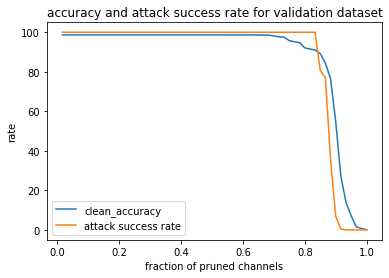

In [44]:
x_axis = np.arange(1,61)/60
plt.plot(x_axis,clean_acc)
plt.plot(x_axis,asrate)
plt.legend(['clean_accuracy','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")

In [45]:
index = np.where(np.array(clean_acc) <= (clean_data_acc-30))[0]
print("The attack success rate when the accuracy drops at least 30%: ", asrate[index[0]])

The attack success rate when the accuracy drops at least 30%:  6.954187234779596


## Combining the models

Here we combine two models which are $B$ (original badnet model) and $B'$ (pruned model). The combined model is the *goodnet*. If the preditions from $B$ and $B'$ are the same then the *goodnet* will output the predition.

In [46]:
class G(keras.Model):
  def __init__(self, B, B_prime):
      super(G, self).__init__()
      self.B = B
      self.B_prime = B_prime

  def predict(self,data):
      y = np.argmax(self.B(data), axis=1)
      y_prime = np.argmax(self.B_prime(data), axis=1)
      pred = np.zeros(data.shape[0])
      for i in range(data.shape[0]):
        if y[i]==y_prime[i]:
          pred[i] = y[i]
        else:
          pred[i] = 1283
      return pred

## Evaluate the combined model

In [48]:
test_data_filename = '/content/drive/MyDrive/Lab2_mm11070/lab3/data/cl/test.h5'
poisoned_test_data_filename = '/content/drive/MyDrive/Lab2_mm11070/lab3/data/bd/bd_test.h5'
test_model_X_2_filename = '/content/model_X=2.h5'
test_model_X_4_filename = '/content/model_X=4.h5'
test_model_X_10_filename = '/content/model_X=10.h5'

In [49]:
test_model_X_2 = keras.models.load_model(test_model_X_2_filename)
test_model_X_4 = keras.models.load_model(test_model_X_4_filename)
test_model_X_10 = keras.models.load_model(test_model_X_10_filename)

Ignore the warnings

In [50]:
x_test_data, y_test_data = data_loader(test_data_filename)
x_test_poisoned_data, y_test_poisnoed_data = data_loader(poisoned_test_data_filename)

In [51]:
print("x_test_data shape: ",x_test_data.shape)
print("x_test_poisoned data shape: ",x_test_poisoned_data.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [52]:
G_model_X_2 = G(model, test_model_X_2)
G_model_X_4 = G(model, test_model_X_4)
G_model_X_10 = G(model, test_model_X_10)

### Evaluating on the test dataset

In [53]:
cl_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_data), axis=1)
clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('2% drops model, the clean test data Classification accuracy:', clean_test_2_accuracy)

bd_test_2_label_p = np.argmax(test_model_X_2.predict(x_test_poisoned_data), axis=1)
asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('2% drops model, Attack Success Rate:', asr_2)

cl_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_data), axis=1)
clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('4% drops model, the clean test data classification accuracy:', clean_test_4_accuracy)

bd_test_4_label_p = np.argmax(test_model_X_4.predict(x_test_poisoned_data), axis=1)
asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('4% drops model, Attack Success Rate:', asr_4)

cl_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_data), axis=1)
clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('10% drops model, the clean test data classification accuracy:', clean_test_10_accuracy)

bd_test_10_label_p = np.argmax(test_model_X_10.predict(x_test_poisoned_data), axis=1)
asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('10% drops model, Attack Success Rate:', asr_10)

401/401 [==============================] - 8s 20ms/step
2% drops model, the clean test data Classification accuracy: 95.90023382696803
401/401 [==============================] - 8s 19ms/step
2% drops model, Attack Success Rate: 100.0
401/401 [==============================] - 8s 19ms/step
4% drops model, the clean test data classification accuracy: 92.29150428682775
401/401 [==============================] - 8s 19ms/step
4% drops model, Attack Success Rate: 99.98441153546376
401/401 [==============================] - 8s 19ms/step
10% drops model, the clean test data classification accuracy: 84.54403741231489
401/401 [==============================] - 8s 19ms/step
10% drops model, Attack Success Rate: 77.20966484801247


### Summarizing the fixed models

Accuracy vs Attack Rate

In [54]:
test_acc = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]
attack_rate = [asr_2, asr_4, asr_10]
data = {
    "text_acc": test_acc,
    "attack_rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%"]
}
df = pd.DataFrame(data)
df.set_index('model')

,text_acc,attack_rate
model,,
repaired_2%,95.900234,100.000000
repaired_4%,92.291504,99.984412
repaired_10%,84.544037,77.209665


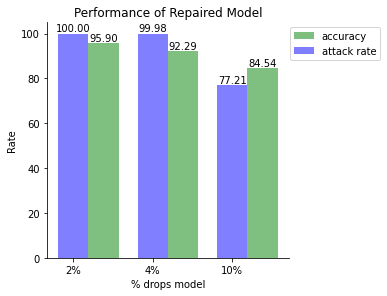

In [65]:
opacity = 0.5
bar_width = 0.38

plt.xlabel('% drops model')
plt.ylabel('Rate')

plt.xticks(range(len(test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(test_acc)) + bar_width, test_acc, bar_width, align='center', alpha=opacity, color='g', label='accuracy')
bar2 = plt.bar(range(len(attack_rate)), attack_rate, bar_width, align='center', alpha=opacity, color='b', label='attack rate')

# Adding value above bar
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('Performance of Repaired Model')
sns.despine()
plt.show()

These are the *goodnets* which combines the two models that are the original badnet and the 'fixed' model

In [56]:
G_cl_test_2_label_p = G_model_X_2.predict(x_test_data)
G_clean_test_2_accuracy = np.mean(np.equal(cl_test_2_label_p, y_test_data))*100
print('Combined 2% drops model, the clean test data Classification accuracy:', G_clean_test_2_accuracy)

G_bd_test_2_label_p = G_model_X_2.predict(x_test_poisoned_data)
G_asr_2 = np.mean(np.equal(bd_test_2_label_p, y_test_poisnoed_data))*100
print('Combined 2% drops model, Attack Success Rate:', G_asr_2)

G_cl_test_4_label_p = G_model_X_4.predict(x_test_data)
G_clean_test_4_accuracy = np.mean(np.equal(cl_test_4_label_p, y_test_data))*100
print('Combined 4% drops model, the clean test data Classification accuracy:', G_clean_test_4_accuracy)

G_bd_test_4_label_p = G_model_X_4.predict(x_test_poisoned_data)
G_asr_4 = np.mean(np.equal(bd_test_4_label_p, y_test_poisnoed_data))*100
print('Combined 4% drops model, Attack Success Rate:', G_asr_4)

G_cl_test_10_label_p = G_model_X_10.predict(x_test_data)
G_clean_test_10_accuracy = np.mean(np.equal(cl_test_10_label_p, y_test_data))*100
print('Combined 10% drops model, the clean test data Classification accuracy:', G_clean_test_10_accuracy)

G_bd_test_10_label_p = G_model_X_10.predict(x_test_poisoned_data)
G_asr_10 = np.mean(np.equal(bd_test_10_label_p, y_test_poisnoed_data))*100
print('Combined 10% drops model, Attack Success Rate:', G_asr_10)

Combined 2% drops model, the clean test data Classification accuracy: 95.90023382696803
Combined 2% drops model, Attack Success Rate: 100.0
Combined 4% drops model, the clean test data Classification accuracy: 92.29150428682775
Combined 4% drops model, Attack Success Rate: 99.98441153546376
Combined 10% drops model, the clean test data Classification accuracy: 84.54403741231489
Combined 10% drops model, Attack Success Rate: 77.20966484801247


In [57]:
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10]
G_data = {
    "G_text_acc": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%"]
}
G_df = pd.DataFrame(G_data)
G_df.set_index('G_model')

,G_text_acc,G_attack_rate
G_model,,
G_2%,95.900234,100.000000
G_4%,92.291504,99.984412
G_10%,84.544037,77.209665


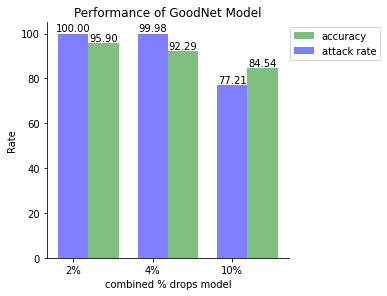

In [66]:
opacity = 0.5
bar_width = 0.38

plt.xlabel('combined % drops model')
plt.ylabel('Rate')

plt.xticks(range(len(G_test_acc)),('2%', '4%', '10%'))
bar1 = plt.bar(np.arange(len(G_test_acc)) + bar_width, G_test_acc, bar_width, align='center', alpha=opacity, color='g', label='accuracy')
bar2 = plt.bar(range(len(G_attack_rate)),G_attack_rate, bar_width, align='center', alpha=opacity, color='b', label='attack rate')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('Performance of GoodNet Model')
sns.despine()
plt.show()

---